In [1]:
import gym
from collections import deque
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

plt.ion()

In [2]:
env = gym.make('MountainCarContinuous-v0')
print('Observation space: ', env.observation_space)
print('Action space: ', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation space:  Box(2,)
Action space:  Box(1,)
  - low: [-1.]
  - high: [1.]


In [17]:
class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        self.s_size = env.observation_space.shape[0]
        self.a_size = env.action_space.shape[0]
        self.h_size = h_size
        
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        a_size = self.a_size
        h_size = self.h_size
        fc1_end = (s_size * h_size) + h_size
        fc1_W = torch.from_numpy(weights[:(s_size * h_size)].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[(s_size * h_size):fc1_end].reshape(h_size))
        fc2_W = torch.from_numpy(weights[fc1_end: fc1_end + (h_size * a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end + (h_size * a_size):])
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        
        for t in range(max_t):
            state = torch.from_numpy(state).float()
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done: 
                break
        
        return episode_return
                        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.tanh(self.fc2(x))
        return x.cpu().data
    
    def get_weights_dim(self):
        return (self.h_size * self.s_size) + self.h_size + (self.h_size * self.a_size) + self.a_size

In [18]:
agent = Agent(env)

In [ ]:
scores = cem()

In [37]:
def cem(n_iterations=500, max_t=1000, gamma=1.0, print_every=100, pop_size=50, elite_frac=0.2, sigma=0.5):
    """
    Params
    ======
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    
    n_elite = int(elite_frac * pop_size)
    
    scores = []
    scores_deque = deque(maxlen=100)
    best_weight = sigma * np.random.randn(agent.get_weights_dim())
    
    for i_iteration in range(1, n_iterations + 1):
        weights_pop = [best_weight + (sigma * np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])
        
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)
        
        reward = agent.evaluate(best_weight, gamma=1.0)
        scores.append(reward)
        scores_deque.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint_cem.pth')
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)), end='')
        
        if i_iteration % print_every == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    
    return scores

In [38]:
env = gym.make('MountainCarContinuous-v0')
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
agent.load_state_dict

while True:
    state = torch.from_numpy(state).float()
    with torch.no_grad():
        action = self.forward(state)
    state, reward, done, info = env.step(action)
    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    if done:
        break

Episode 100	Average Score: -2.49
Episode 100	Average Score: -2.49
Episode 200	Average Score: -0.30
Episode 200	Average Score: -0.30
Episode 300	Average Score: -0.77
Episode 300	Average Score: -0.77
Episode 400	Average Score: 84.37
Episode 400	Average Score: 84.37
Episode 413	Average Score: 90.89
Environment solved in 313 iterations!	Average Score: 90.89


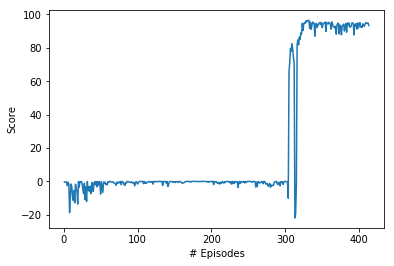

In [39]:
figure = plt.figure()
ax = figure.add_subplot(111)
plt.plot(range(1, len(scores) + 1), scores)
plt.xlabel('# Episodes')
plt.ylabel('Score')
plt.show()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


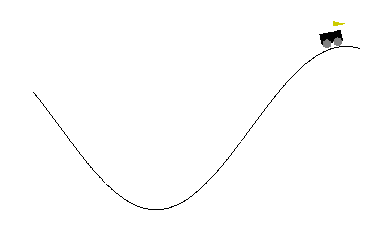

In [41]:
env = gym.make('MountainCarContinuous-v0')
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
agent.load_state_dict(torch.load('checkpoint_cem.pth'))

while True:
    state = torch.from_numpy(state).float()
    with torch.no_grad():
        action = agent.forward(state)
    state, reward, done, info = env.step(action)
    img.set_data(env.render(mode='rgb_array'))
    plt.axis('off')
    if done:
        break